In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

def compare_models(models):
    """
    Compare metrics across multiple models.
    
    Args:
        models (list): List of model names to compare (e.g., ['distilbert-cased', 'distilbert-uncased', 'mobileLLM-125M'])
    """
    # Dictionary to store DataFrames for each model
    dfs = {}
    
    # Standardize column name mappings
    column_mappings = {
        "Epoch": "epoch", 
        "Loss": "loss",
        "Accuracy": "accuracy",
        "Precision": "precision",
        "Recall": "recall",
        "F1-score": "f1_score",
        "Time (s)": "time_taken"
    }
    
    # Load data for each model
    for model in models:
        model_path = f"model-metric/{model}"
        
        # For JSON files (mobileLLM)
        if "mobileLLM" in model:
            with open(f"{model_path}/training_metrics.json", "r") as f:
                model_data = json.load(f)
            df = pd.DataFrame(model_data)
            
        # For CSV files (distilbert models)
        else:
            df = pd.read_csv(f"{model_path}/training_metrics.csv")
            print(f"Original columns for {model}: {df.columns.tolist()}")
            
            # Standardize column names
            rename_dict = {}
            for orig, new in column_mappings.items():
                if orig in df.columns:
                    rename_dict[orig] = new
            
            if rename_dict:
                df.rename(columns=rename_dict, inplace=True)
        
        # Add model name for identification
        # Format model name for display (capitalize, add hyphen/space as needed)
        display_name = model
        if "distilbert" in model.lower():
            if model.lower()=='distilbert-cased':
                display_name = "DistilBERT-CASED"
            elif model.lower()=='distilbert-uncased':
                display_name = "DistilBERT-UNCASED"
        elif "mobilellm" in model.lower():
            display_name = "MobileLLM"
            
        df["model"] = display_name
        dfs[display_name] = df
        
        # Print to verify the dataframe for debugging
        print(f"Model: {display_name}, Shape: {df.shape}")
        print(f"First few rows for {display_name}:")
        print(df.head(2))
    
    # Concatenate all DataFrames
    combined_df = pd.concat(list(dfs.values()), ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    print(f"Models in combined DataFrame: {combined_df['model'].unique()}")
    
    # Get available metrics (intersection of columns across all dataframes)
    available_metrics = []
    standard_metrics = ["loss", "accuracy", "precision", "recall", "f1_score"]
    
    for metric in standard_metrics:
        if all(metric in df.columns for df in dfs.values()):
            available_metrics.append(metric)
    
    print(f"Available metrics for comparison: {available_metrics}")
    
    if not available_metrics:
        print("No common metrics found across all models. Check column names.")
        return
    
    # Color mapping for each model
    colors = {
        "DistilBERT-CASED": "green",
        "DistilBERT-UNCASED": "blue",
        "MobileLLM": "red"
    }
    
    # Line style and marker mapping
    line_styles = {
        "DistilBERT-CASED": "solid",
        "DistilBERT-UNCASED": "solid",
        "MobileLLM": "dashed"
    }
    
    markers = {
        "DistilBERT-CASED": "^",
        "DistilBERT-UNCASED": "o",
        "MobileLLM": "s"
    }
    
    # Calculate number of required subplots
    num_metrics = len(available_metrics)
    rows = (num_metrics + 2) // 3  # Adding 2 to account for time plot
    
    # Plot settings
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(rows, min(3, num_metrics), figsize=(18, 6*rows))
    
    # Handle single subplot case
    if num_metrics == 1:
        axes = np.array([axes])
    
    # Flatten axes for easier iteration
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    # Generate subplots for each metric
    for i, metric in enumerate(available_metrics):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        # Direct plotting without trying to determine scales
        # Plot all models on the same axis
        for model_name, df in dfs.items():
            if metric in df.columns:
                sns.lineplot(
                    data=df, 
                    x="epoch", 
                    y=metric, 
                    ax=ax, 
                    label=model_name, 
                    color=colors.get(model_name, "gray"), 
                    marker=markers.get(model_name, "o"),
                    linestyle=line_styles.get(model_name, "solid")
                )
        
        # Titles and labels
        metric_title = metric.replace('_', ' ').capitalize()
        ax.set_title(f"{metric_title} Comparison", fontsize=14, fontweight='bold')
        ax.set_xlabel("Epoch", fontsize=12)
        ax.set_ylabel(f"{metric_title}", fontsize=12)
        ax.legend(loc="best", fontsize=10)
    
    # Add time comparison in the remaining subplot if there's space
    time_idx = len(available_metrics)
    if time_idx < len(axes):
        ax = axes[time_idx]
        for model_name, df in dfs.items():
            if "time_taken" in df.columns:
                sns.lineplot(
                    data=df, 
                    x="epoch", 
                    y="time_taken", 
                    ax=ax, 
                    label=model_name, 
                    color=colors.get(model_name, "gray"), 
                    marker=markers.get(model_name, "o"),
                    linestyle=line_styles.get(model_name, "solid")
                )
        
        ax.set_title("Training Time Per Epoch", fontsize=14, fontweight='bold')
        ax.set_xlabel("Epoch", fontsize=12)
        ax.set_ylabel("Time (seconds)", fontsize=12)
        ax.legend(loc="best", fontsize=10)
    
    # Hide any unused subplots
    for j in range(max(time_idx + 1, len(available_metrics)), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()

Original columns for distilbert-cased: ['Epoch', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Time (s)']
Model: DistilBERT-CASED, Shape: (10, 8)
First few rows for DistilBERT-CASED:
   epoch      loss  accuracy  precision    recall  f1_score  time_taken  \
0      1  1.794946  0.188889   0.248739  0.188889  0.173102  144.228101   
1      2  1.742875  0.382222   0.426707  0.382222  0.363803  137.425677   

              model  
0  DistilBERT-CASED  
1  DistilBERT-CASED  
Original columns for distilbert-uncased: ['Epoch', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Time (s)']
Model: DistilBERT-UNCASED, Shape: (10, 8)
First few rows for DistilBERT-UNCASED:
   epoch      loss  accuracy  precision    recall  f1_score  time_taken  \
0      1  1.788121  0.215556   0.295419  0.215556  0.157102  158.836667   
1      2  1.711829  0.382222   0.467113  0.382222  0.358350  154.476734   

                model  
0  DistilBERT-UNCASED  
1  DistilBERT-UNCASED  
Model: MobileLLM, 

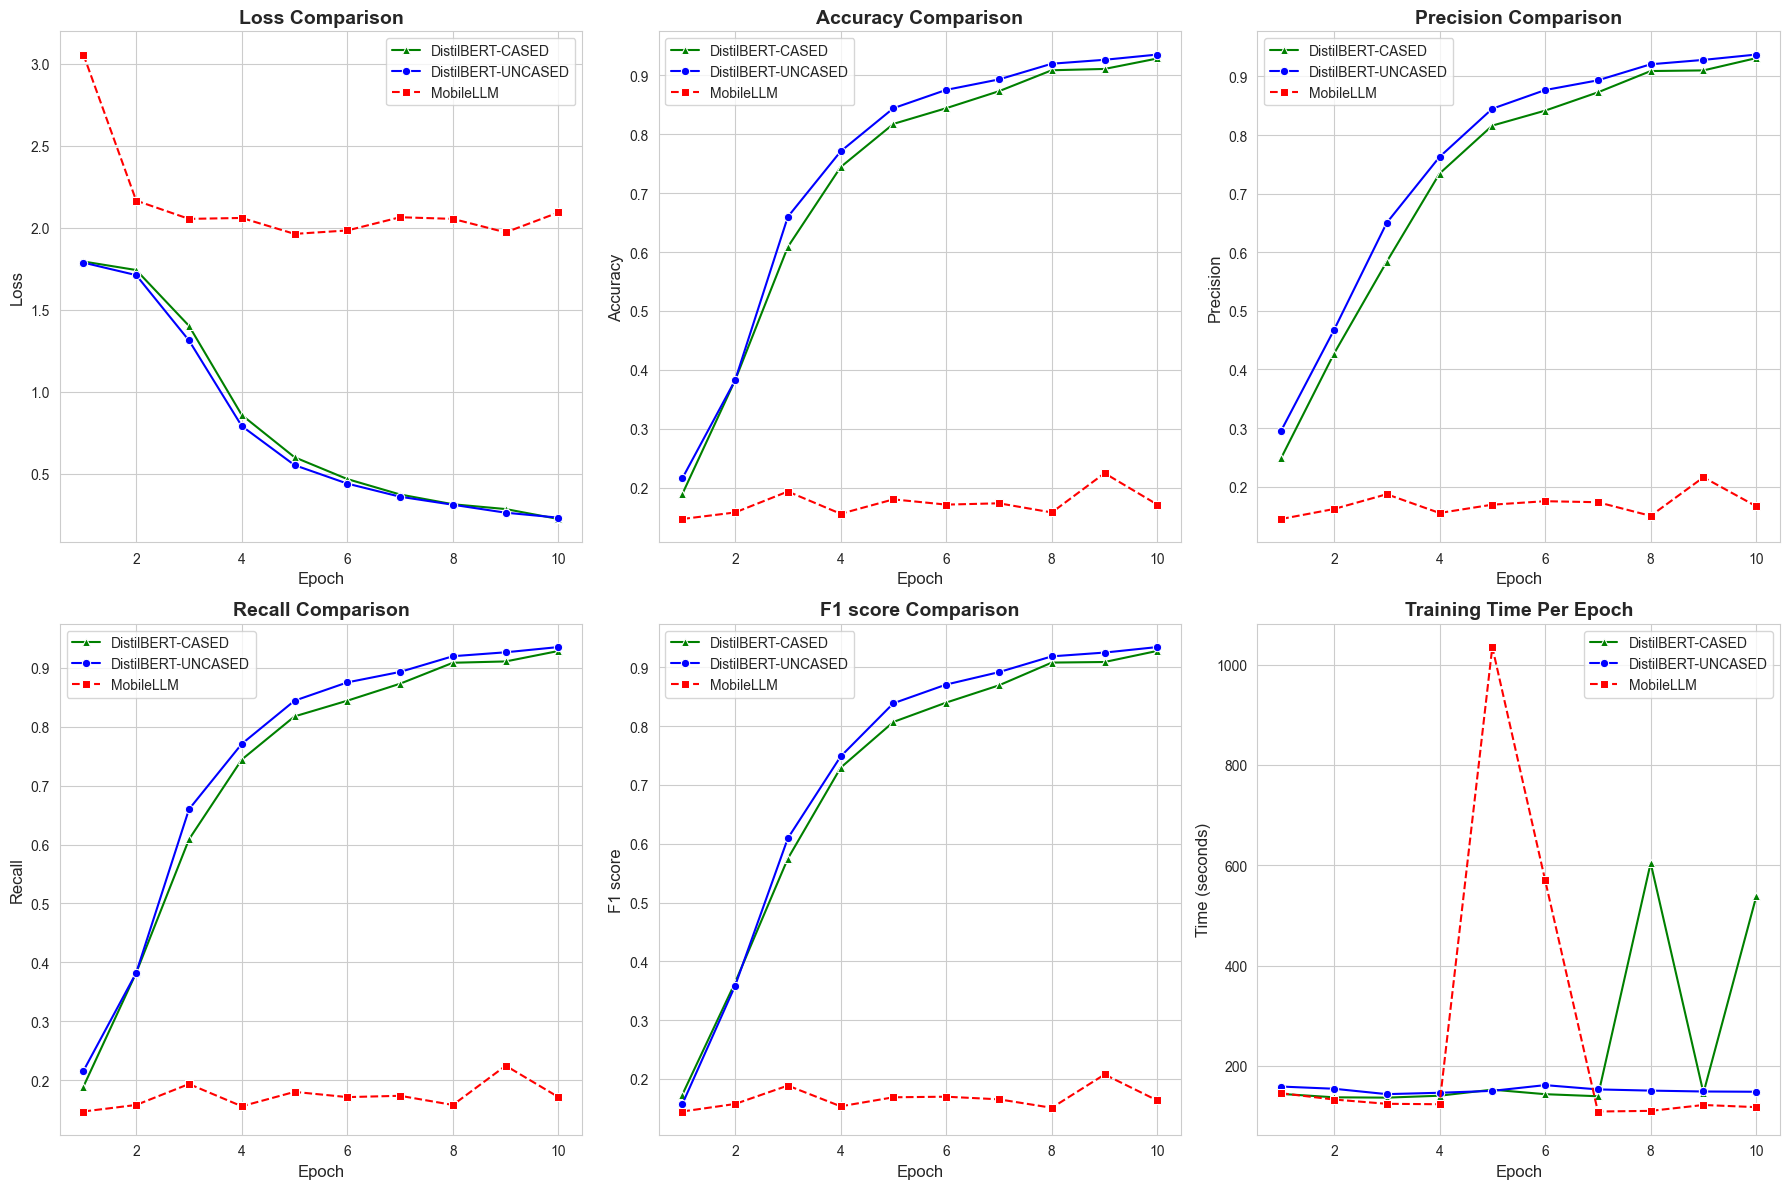

In [13]:
# Example usage:
models = ['distilbert-cased', 'distilbert-uncased','mobileLLM-125M']
compare_models(models)